To simulate data in Python people generally use NumPy or SciPy.
Their interfaces are simple and easy to use.
For example, to simulate values from a normal distribution, `np.random.normal()` is all we need.

But not all the scenarios where one may want to simulate data are as simple as our example above.
In statistics, quite often we want to perform parameter recovery studies.
These tell us if our model and estimation procedure are able to recover the true value of the
parameters of the assumed data generating process.

To perform a parameter recovery study we roughly follow the steps below:

1. Define model (input variables, parameters, and output variables)
2. Set model parameters to some plausible values
3. Simulate values of the outcome variable
4. Estimate the parameters
5. Compare the parameter estimates against the true values

If we wanted to do this using NumPy, we would need to write the model from scratch using functions in its `random` module.
In general, when our goal is to perform estimation and prediction, we don't write models from scratch in NumPy.
Rather, we use the interface provided by another library that usually comes with the tools needed to do estimation, criticism, prediction, etc.

What the previous paragraph highlights is that, at the end of the day, the model is implemented twice.
One implementation is used to carry out simulation and parameter recovery, the other is used to estimate the parameters.
As the complexity of the model increases, it becomes harder and harder to not make mistakes in the
implementation of our model in a pure NumPy or SciPy approach.

Fortunately, for those of us following a Bayesian approach, there's PyMC.
The model representation in PyMC gives users the possibility to do both simulation and estimation using the same model object.

Through a series of examples of increasing complexity, I'm going to show how to simulate data with PyMC in the context of a parameter recovery study.
In our journey, we'll learn about some quite PyMC specific terminologies and functions such as:

* `pm.draw()`
* `pm.do()` and `pm.observe()`
* `coords` and `dims`
* `pm.Data` and `pm.Deterministic`

Hopefully, the groupings will make sense by the end of the post.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
seed = sum(map(ord, "happy data simulation"))  # A fancy way to determine a seed
rng = np.random.default_rng(seed)              # Random number generator

## A simple normal model

It all starts with a very simple model. There's an outcome variable $Y$ which we model with a normal distribution, and we're interested in the estimation of the mean and standard deviation parameters, $\mu$ and $\sigma$.

$$
\begin{aligned}
Y_i \mid \mu, \sigma    &\sim \text{Normal}(\mu, \sigma^2) \\
\mu &\sim \text{Normal}(0, 1^2) \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$. In this case, as we're starting small, we ill use $N = 10$.

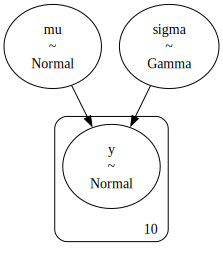

In [3]:
N = 10

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1) # <1>
    sigma = pm.Gamma("sigma", alpha=2, beta=2) # <2>
    pm.Normal("y", mu=mu, sigma=sigma, shape=N) # <3>

model.to_graphviz()

1. Prior for $\mu$
2. Prior for $\sigma$
3. The observational model. `shape=N` indicates there are `N` values of `y`.

Notice we have created a PyMC model without having any observed data. If you're already familiar with PyMC, don't look for the `observed` keyword in the distribution for $Y$, you won't find it.

To simulate values from a PyMC distribution, there's the very handy `pm.draw()` function. It does what its name says: draws samples from a probability distribution^[You could also say it generates values from a random variable].

Let's draw a value from the distribution of $\mu$:

In [4]:
pm.draw(mu)

array(-0.32857606)

Do you want many values? No problem.

In [5]:
pm.draw(mu, draws=10)

array([ 1.92105562,  0.29831206, -0.90112025,  0.01240051, -0.73141058,
        0.62951793,  0.25498252,  1.24128921,  1.2926445 ,  0.19844168])

And reproducibility? It has you covered with `random_seed`. One can pass an integer seed or a random number generator. I prefer the latter and I will use it everywhere in this blog post.

In [6]:
pm.draw(sigma, random_seed=rng)

array(0.66709727)

Finally, the last thing I'm going to say about `pm.draw()` is that it accepts a sequence of random variables. Below we get a draw for both $\mu$ and $\sigma$.

In [7]:
mu_value, sigma_value = pm.draw([mu, sigma], random_seed=rng)
mu_value, sigma_value

(array(-0.64551614), array(0.29948268))

The next step is to set these parameter values in the model. This is where the `pm.do()` function comes into play. The name of the function comes from the causal inference literature and it is used to perform "interventions" in a model graph. For our purposes, we can think of it as a way to assign specific values to model parameters. If you're curious about it you can have a look at [Causal analysis with PyMC: Answering "What If?" with the new do operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/) and [Interventional distributions and graph mutation with the do-operator](https://www.pymc.io/projects/examples/en/latest/causal_inference/interventional_distribution.html).

Let’s get back to our topic. To assign values to model parameters using `pm.do()`, we pass it a model instance and a dictionary that maps variable names to values. The output we obtain is a new PyMC model instance.

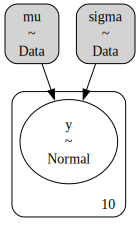

In [8]:
model_fixed_parameters = pm.do(model, {"mu": mu_value, "sigma": sigma_value})
model_fixed_parameters.to_graphviz()

In this new instance, the nodes for `mu` and `sigma` got updated. They don't represent random variables anymore, they represent and "contain" constant values.

Now that parameter values are fixed, we need to simulate values from the outcome variable `y`. Again, we use `pm.draw()`. Notice we access the random variable `y` from the model object, as there's no global variable that represents it.

In [9]:
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
y_values

array([-0.93216552, -0.37497902,  0.02807845, -0.53793148, -0.99724182,
       -0.77754811, -0.60105837, -0.34428665, -0.63623636, -0.66625698])

The next step is to set the "observed" values of the outcome variable in the original model, where `mu` and `sigma` are random variables. This is where `pm.observe()` comes into play. Unlike `pm.do()`, `pm.observe()` doesn't convert random variables into fixed quantities. Instead, it attaches observed values —realizations of these random variables— that are later used to condition inference.

The usage is similar to `pm.do()`. We pass a model, a dictionary mapping variables to values, and it returns a new PyMC model.

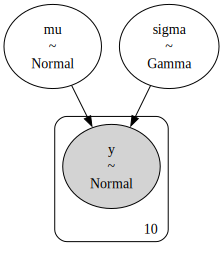

In [10]:
model_observed_data = pm.observe(model, {"y": y_values})
model_observed_data.to_graphviz()

Finally, we're in a position where we can perform inference and evaluate whether the posterior concentrates around the parameter value used to simulate the values of the outcome.

In [11]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


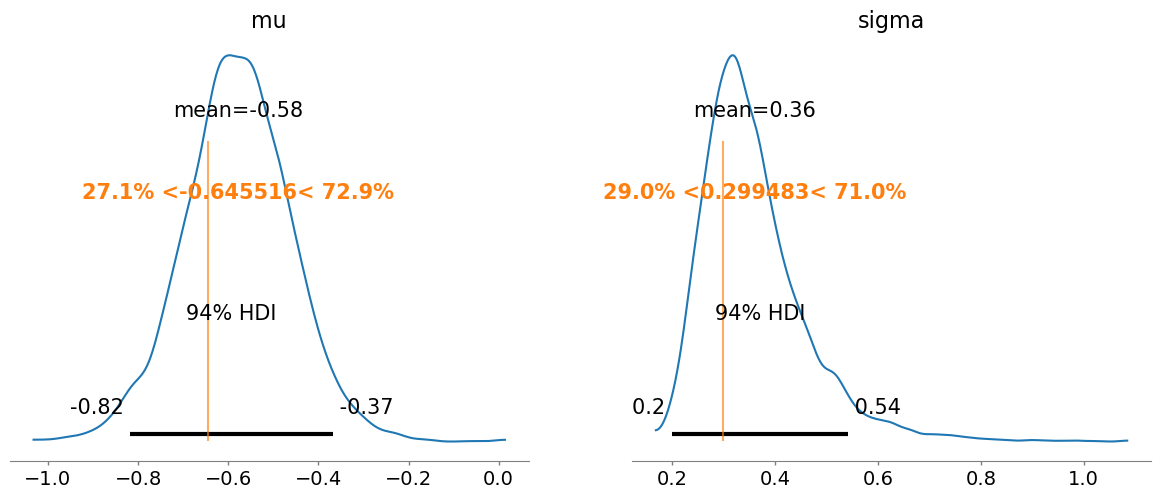

In [12]:
az.plot_posterior(idata, ref_val=[mu_value, sigma_value]);

And everything worked as expected.

### Summary

Since we're going to follow the same steps in all the examples below, let's summarise them here for reference.

1. Define model (input variables, parameters, and output variables)

```python
N = 10

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    pm.Normal("y", mu=mu, sigma=sigma, shape=N)
```

2. Set model parameters to some plausible values

```python
mu_value, sigma_value = pm.draw([mu, sigma], random_seed=rng)
model_fixed_parameters = pm.do(model, {"mu": mu_value, "sigma": sigma_value})
```

3. Simulate values of the outcome variable

```python
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
```

4. Estimate the parameters

```python
model_observed_data = pm.observe(model, {"y": y_values})
with model_observed_data:
    idata = pm.sample(random_seed=rng)
```

5. Compare the parameter estimates against the true values

```python
az.plot_posterior(idata, ref_val=[mu_value, sigma_value]);
```

Before moving on to the next example, some clarification notes:

* You don't need to use the prior to simulate parameter values. You could do `pm.do()` with arbitrary values, as long as they are within the parameter domain.
* This is not a post about thorough parameter recovery, just something basic that conveys the idea. Don't take it as a gold standard.

## Simple linear regression

Let's work with the following simple linear regression model:

$$
\begin{aligned}
Y_i \mid \mu_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim \text{Normal}(0, 1^2) \\
\beta &\sim \text{Normal}(0, 1^2) \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$

### Known covariate values

Usually, the values of the covariate are assumed to be fixed and known. We start with a scenario where we have the values for it, and later, we show how to simulate data for both covariate and outcome variables.

In [13]:
x_values = np.array(
    [
        0.786, -0.399,  1.018,  0.657, -0.195, -0.083,  0.651, -0.476, -0.584, -0.194,
        0.282,  0.176, -0.309,  2.022,  0.341, -0.982, -0.904,  0.491, -2.07 , -0.568
    ]
)

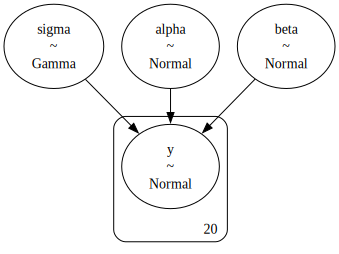

In [14]:
N = 20

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)

    mu = alpha + beta * x_values
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

The steps below are analogous to the ones above. It only changes the random variables which we sample from.

alpha: 0.6559553890005595
beta: -0.2818584784669223
sigma: 2.9596230424561605


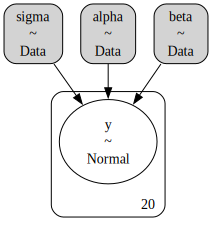

In [15]:
# Get plausible values for the parameters
alpha_value, beta_value, sigma_value = pm.draw([alpha, beta, sigma], random_seed=rng)

print("alpha:", alpha_value)
print("beta:", beta_value)
print("sigma:", sigma_value)

# Set parameters to the sampled values
model_fixed_parameters = pm.do(
    model,
    {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value}
)

model_fixed_parameters.to_graphviz()

Given the fixed parameter values, and the values of the covariate, simulate values of the response `y`.

In [16]:
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
y_values

array([ 3.12686173, -0.11044308, -4.05742728,  2.9712478 ,  1.03231454,
       -0.77103352,  0.42986971,  2.32298661,  2.22334492,  4.25858143,
       -1.75237172, -0.51776157,  3.27740227,  1.12482262, -4.2394528 ,
        0.77089266,  4.45871827,  5.20353471,  0.61391209,  3.22912347])

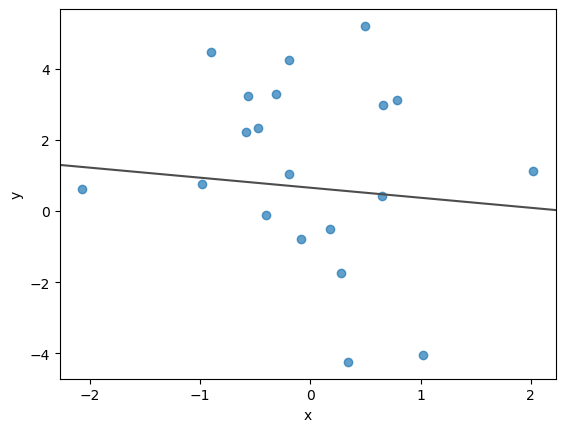

In [17]:
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3") # theoretical line curve
ax.set(xlabel="x", ylabel="y");

Observe the simulated values of `y` in the original model:

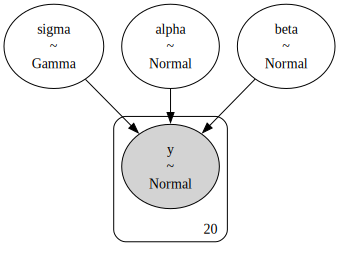

In [18]:
model_observed_data = pm.observe(model, {"y": y_values})
model_observed_data.to_graphviz()

and perform inference.

In [19]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Again, the true parameter value is very well contained in the posterior distribution.

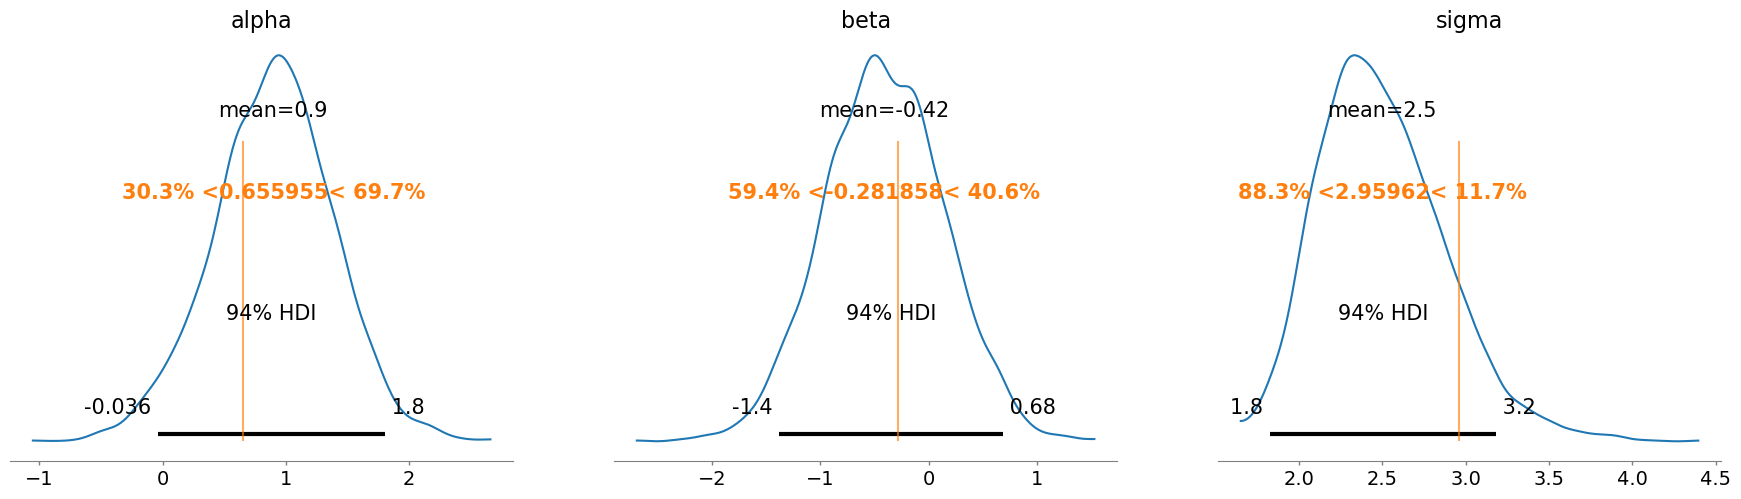

In [20]:
az.plot_posterior(idata, ref_val=[alpha_value, beta_value, sigma_value]);

We can also simulate some draws of the posterior regression line.

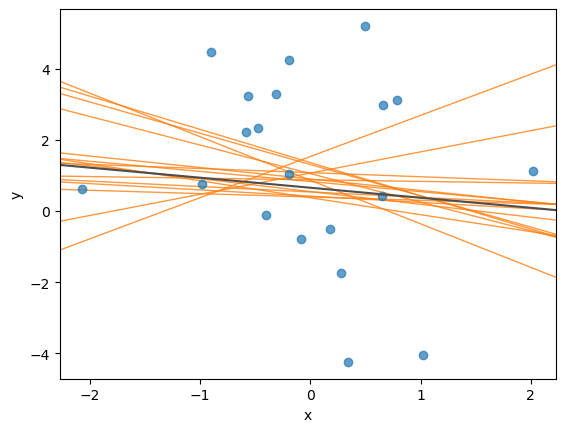

In [21]:
posterior_draws = az.extract(
    idata, group="posterior", var_names=["alpha", "beta"], num_samples=15
)

fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3")

for a, b in zip(posterior_draws["alpha"].to_numpy(), posterior_draws["beta"].to_numpy()):
    ax.axline((0, a), slope=b, color="C1", alpha=0.8, lw=1, zorder=-1)

ax.set(xlabel="x", ylabel="y");

### Unknown covariate values

We may need to simulate values for `x` either because we don't yet have values for the covariate or because we want to evaluate different scenarios.

The process is very similar to what we've done so far, but now we need to specify a distribution for `x` to determine how its values are generated. There is a huge variety of choices. Here I'm going to default to a standard normal distribution.

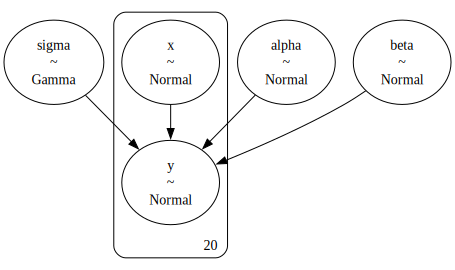

In [22]:
N = 20

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    x = pm.Normal("x", shape=N) # there are as many 'x' values as observations

    mu = alpha + beta * x
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

Everything else stays the same:

alpha: 0.1719973000588151
beta: 0.6008524215503052
sigma: 1.1351657143542704

x values:
[-0.07292669 -0.54826599 -0.46954908  0.26994204  1.00053203  0.65220785
 -1.52515351  0.51970338 -0.51429822 -0.26137883 -0.47653569  0.16923646
 -0.93059417  0.45502837 -1.05738506 -0.61663942 -0.52632527  0.34543959
 -0.04647066  1.32000584]


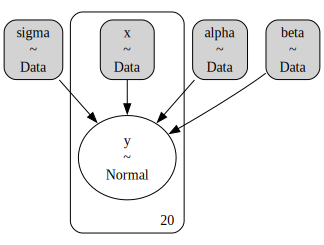

In [23]:
# Get plausible values for the parameters
alpha_value, beta_value, sigma_value, x_values = pm.draw([alpha, beta, sigma, x], random_seed=rng)

print("alpha:", alpha_value)
print("beta:", beta_value)
print("sigma:", sigma_value)

print("\nx values:", x_values, sep="\n")

# Set parameters to the sampled values
model_fixed_parameters = pm.do(
    model,
    {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value, "x": x_values}
)

model_fixed_parameters.to_graphviz()

In [24]:
# Simulate values for the outcome variable
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
print("y values:", y_values, sep="\n")

y values:
[ 1.71790428 -0.0682522  -1.26126753 -0.9484205  -0.06096033  0.28471004
 -0.40986102  0.38968251 -2.03112939  1.44298618  0.99584892 -0.46963706
  0.99470417  0.2107016   0.50460528 -0.72376308  1.58806132  0.28525278
  0.71371689  2.99055351]


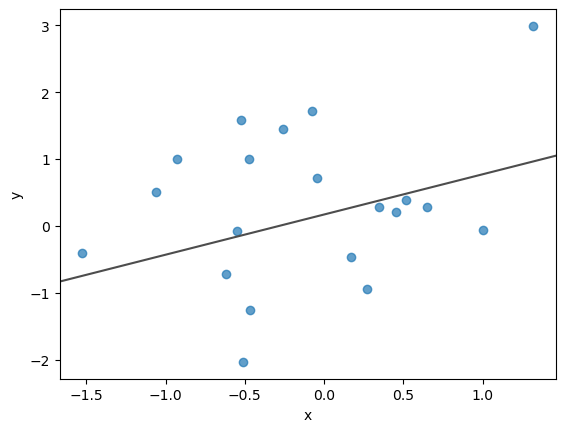

In [25]:
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3");
ax.set(xlabel="x", ylabel="y");

And observe the simulated values of `y` in the original model.

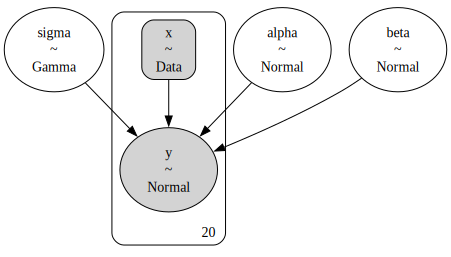

In [26]:
model_observed_data = pm.observe(pm.do(model, {"x": x_values}), {"y": y_values})
model_observed_data.to_graphviz()

Wait for a second and have a second look at the code above. See that we're using **both** `pm.do()` and `pm.observe()`. We first need to use `pm.do()` to set the values of `x` in the original model, and then we need to use `pm.observe()` to attach observed values to the outcome variable `y`. We can't pass the values of `x` through `pm.observe()` because that would mean they are not fixed values, but realizations from a random variable.

To conclude, let's explore the posterior.

In [27]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


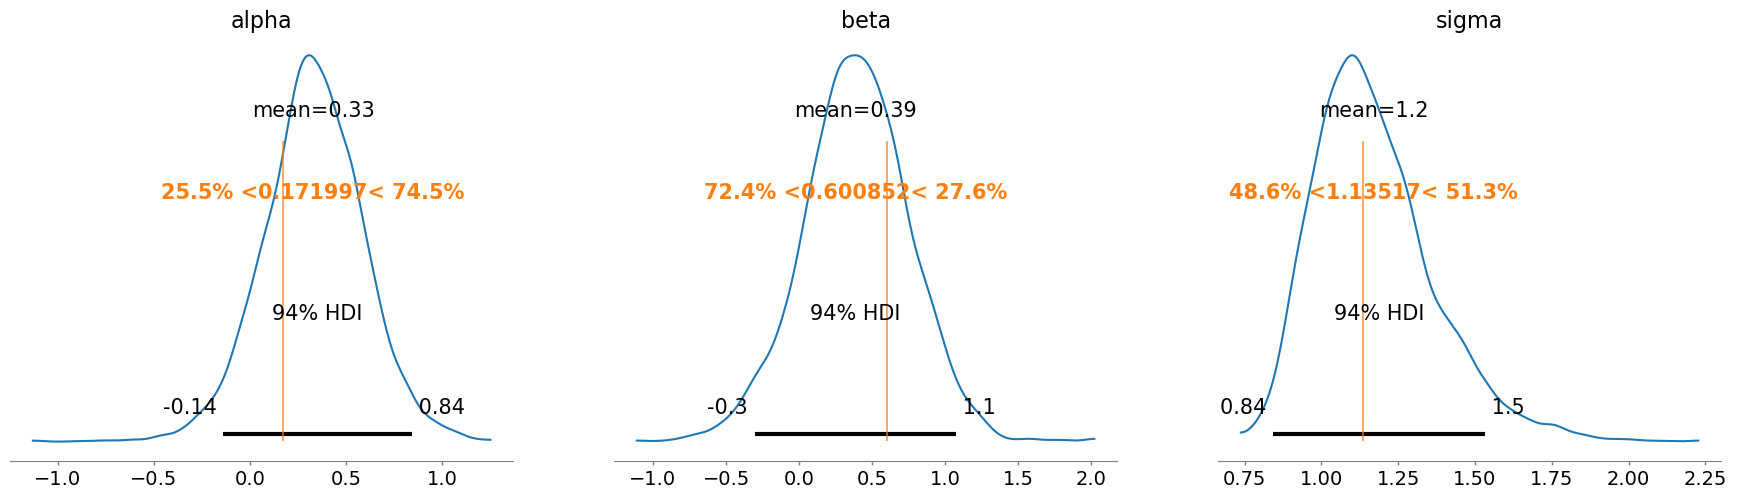

In [28]:
az.plot_posterior(idata, ref_val=[alpha_value, beta_value, sigma_value]);

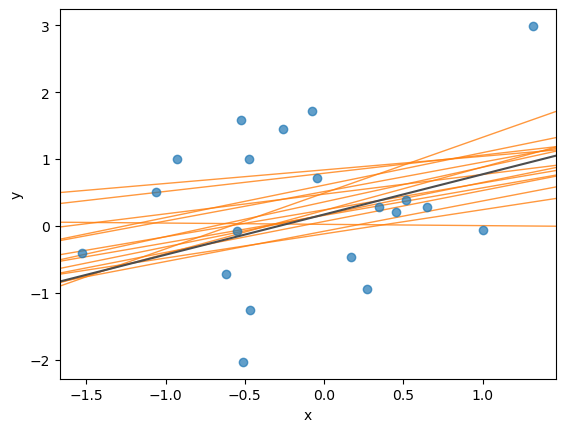

In [29]:
posterior_draws = az.extract(
    idata, group="posterior", var_names=["alpha", "beta"], num_samples=15
)

fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3")

for a, b in zip(posterior_draws["alpha"].to_numpy(), posterior_draws["beta"].to_numpy()):
    ax.axline((0, a), slope=b, color="C1", alpha=0.8, lw=1, zorder=-1)

ax.set(xlabel="x", ylabel="y");

## Normal model for multiple groups

The following model is a simple extension of the first one, where we have multiple groups with different population means.

$$
\begin{aligned}
Y_i     &\sim \text{Normal}(\mu_{j[i]}, \sigma^2) \\
\mu_j   &\sim \text{Normal}(0, 3^2) & \text{for all } j \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$ and $j = 1, \dots, J$.

The indexing notation in $\mu_{j[i]}$ is read as "the value of $j$ for the $i$-th observation". You can also see $j[i]$ as a function call, where you pass the index of an observation and it gives you the value of the group it belongs to.

### Known group membership

Let's start with a simple example, where:

* All groups have the same, pre-defined, sample size.
* Group memberships are known.
* Observations are sorted by group.

In [30]:
J = 4        # Number of groups
n_j = 20     # Number of observations per group
N = J * n_j  # Total number of observations

# Generate group indexes
group_idx = np.repeat(np.arange(J), n_j)
print("Group indexes:")
print(group_idx)

Group indexes:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


The first 20 observations are from the first group, the second 20 observations are from the second group, and so on.

Let's write the model in PyMC. Since we have as many means as groups, we need to pass `shape=J` when we define the prior for $\mu$. Notice we create an intermediate variable `mu_indexed` that contains the value of `mu` for each observation, according to their group.

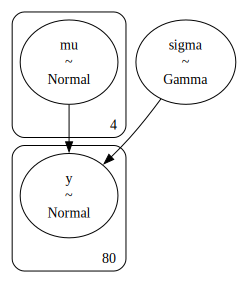

In [31]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=3, shape=J)
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    mu_indexed = mu[group_idx]
    pm.Normal("y", mu=mu_indexed, sigma=sigma, shape=N)

model.to_graphviz()

In [32]:
mu_values, mu_indexed_values, sigma_value = pm.draw([mu, mu_indexed, sigma], random_seed=rng)
print("mu:", mu_values)
print("sigma:", sigma_value)

mu: [6.05496819 1.16678048 2.30070048 4.72798215]
sigma: 0.5873507289564738


As expected, there are 4 values for `mu`. Let's have a look at the values for `mu_indexed_values`.

In [33]:
mu_indexed_values

array([6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       4.72798215, 4.72798215, 4.72798215, 4.72798215, 4.72798215,
       4.72798215, 4.72798215, 4.72798215, 4.72798215, 4.72798215,
       4.72798215, 4.72798215, 4.72798215, 4.72798215, 4.72798

The result is not a coincidence. The first 20 values are the first value of `mu`, the second 20 values are the second value of `mu`, and so on. This is because observations are sorted by group.

The usage of `pm.do()` is the same as always.

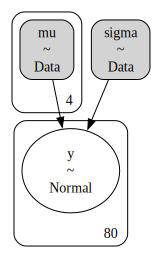

In [34]:
model_fixed_parameters = pm.do(model, {"mu": mu_values, "sigma": sigma_value})
model_fixed_parameters.to_graphviz()

And the same logic applies to the simulation of the values of `y`.

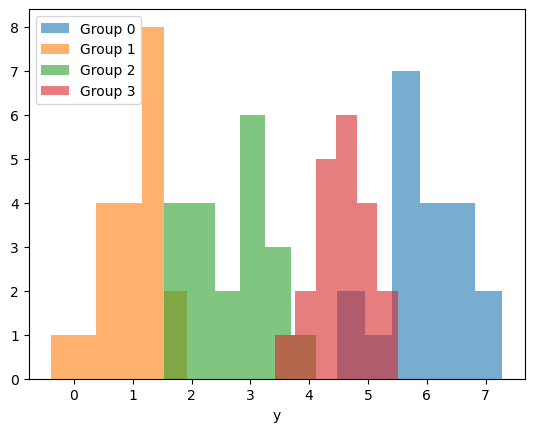

In [35]:
# Simulate values
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Plot empirical distributions
fig, ax = plt.subplots()

for j in range(J):
    ax.hist(y_values[group_idx == j], bins=6, alpha=0.6, label=f"Group {j}")
ax.legend()
ax.set(xlabel="y");

Now let's set the observed values, sample the posterior and explore it.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


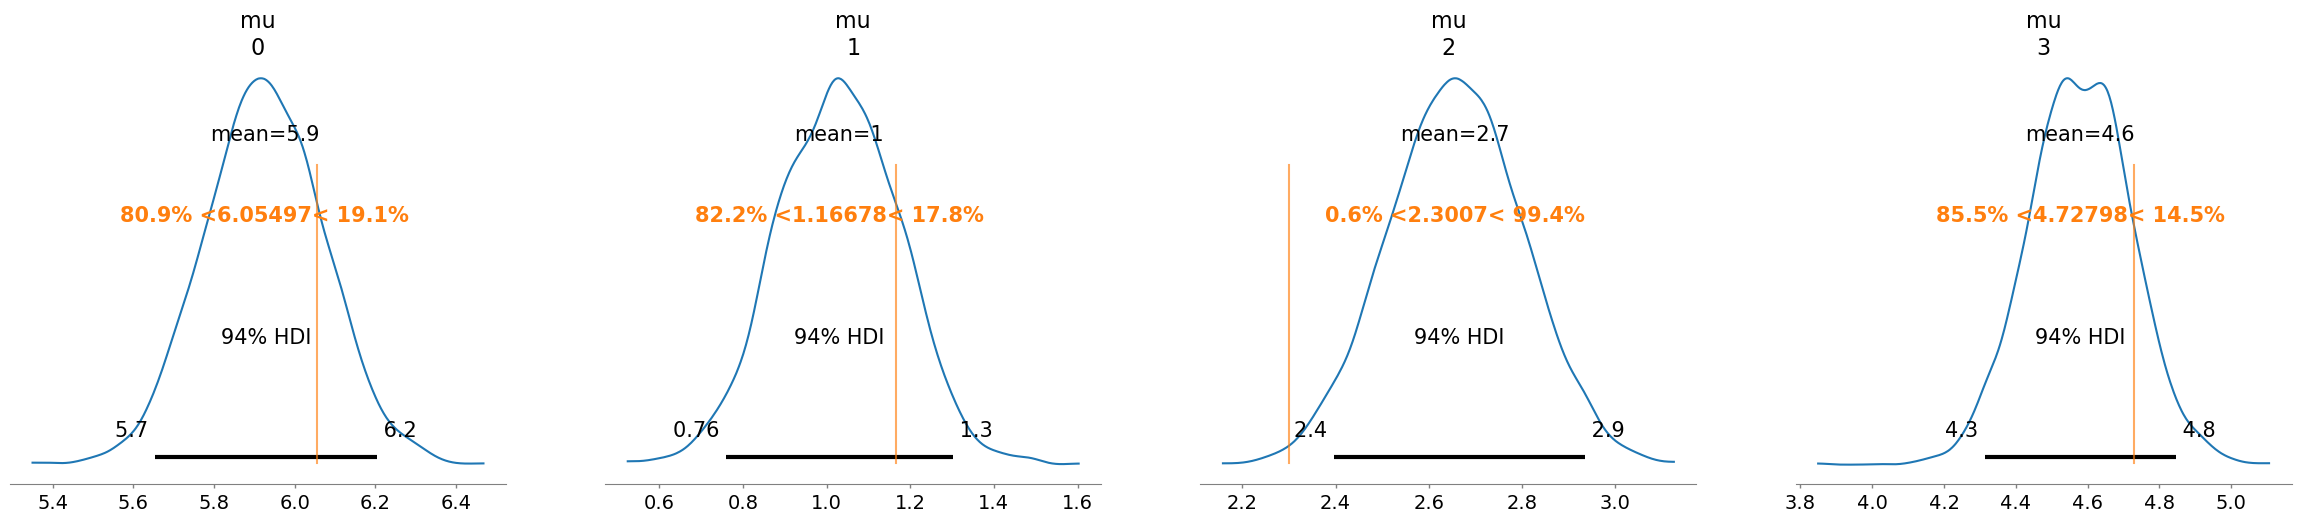

In [36]:
model_observed_data = pm.observe(model, {"y": y_values})

with model_observed_data:
    idata = pm.sample(random_seed=rng)

az.plot_posterior(idata, var_names=["mu"], ref_val=mu_values.tolist());

We can also make use of `pm.sample_posterior_predictive()` to get draws of the posterior predictive distribution.

In [37]:
with model_observed_data:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y]


Output()

This allows us to plot the predictive distribution for each group, where we can see they differ in location but not in dispersion.

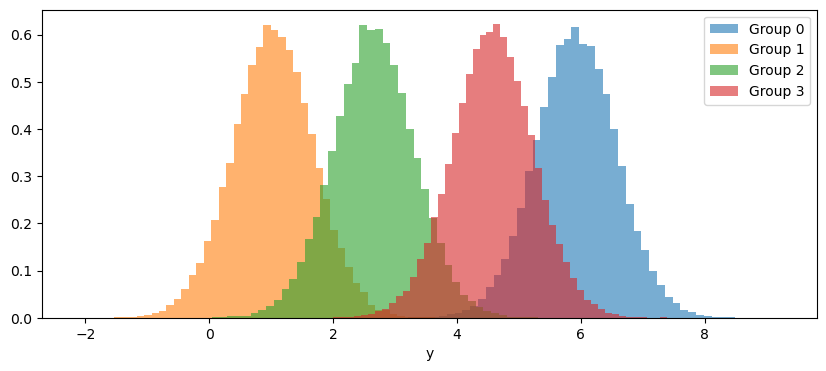

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))

for j in range(J):
    predictive_values = idata.posterior_predictive["y"].to_numpy()[..., group_idx == j].flatten()
    ax.hist(predictive_values, bins=50, alpha=0.6, label=f"Group {j}", density=True)
ax.legend()
ax.set(xlabel="y");

### Unknown group membership

$$
\begin{aligned}
Y_i     &\sim \text{Normal}(\mu_{j[i]}, \sigma^2) \\
\mu_j &\sim \text{Normal}(0, 3^2) & \text{for all } j \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$ and $j = 1, \dots, J$.

The model is exactly the same as the one in the previous section. The difference is that we don't know how many observations belong to each group -- we also want to simulate that.

To simulate group memberships we need a distribution that gives us integers between $0$ and $J-1$. One such distribution is the discrete uniform distribution.

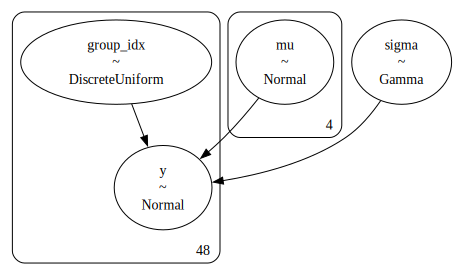

In [39]:
J = 4    # Number of groups
N = 48   # Total number of observations

with pm.Model() as model:
    group_idx = pm.DiscreteUniform("group_idx", lower=0, upper=J-1, shape=N)
    mu = pm.Normal("mu", mu=0, sigma=3, shape=J)
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    pm.Normal("y", mu=mu[group_idx], sigma=sigma, shape=N)

model.to_graphviz()

In [40]:
mu_values, sigma_value, group_idx_values = pm.draw([mu, sigma, group_idx], random_seed=rng)

print("mu:", mu_values)
print("sigma:", sigma_value)
print("group indexes:", group_idx_values, sep="\n")

mu: [ 4.39222186  3.06006526 -1.82575653  3.42869414]
sigma: 0.36418924500311767
group indexes:
[2 0 0 2 1 3 2 0 2 2 3 3 3 3 3 0 3 0 3 3 3 0 3 1 2 2 1 2 2 0 3 0 3 2 3 0 0
 0 1 0 1 0 0 2 0 0 2 3]


Not only the observations are not sorted by group anymore, but also group sizes differ.

In [41]:
np.unique(group_idx_values, return_counts=True)

(array([0, 1, 2, 3]), array([16,  5, 12, 15]))

All the rest is exactly the same:

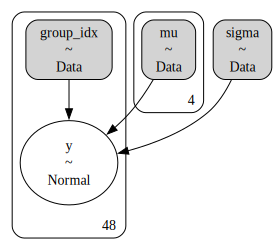

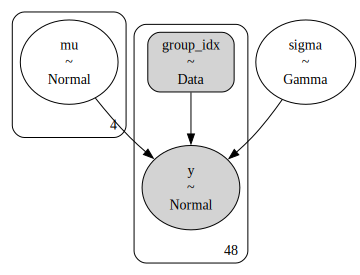

In [42]:
# Fix model parameters and data
model_fixed_parameters = pm.do(
    model,
    {"mu": mu_values, "sigma": sigma_value, "group_idx": group_idx_values}
)

# Display model graph
display(model_fixed_parameters.to_graphviz())

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Fix group indexes and observe the outcome values
model_observed_data = pm.observe(
    pm.do(model, {"group_idx": group_idx_values}),
    {"y": y_values}
)

display(model_observed_data.to_graphviz())

And so on...

## Good practices

Here I want to mention a few practices that are recommended when one works with PyMC models.
They don't change the workflow we previously followed, but they make everything we do with out model more robust and, once familiar, intuitive.

### Use `pm.Data` containers to register data variables

After using the do operator to fix parameters as constants,
the corresponding nodes will display a `Data` label,
indicating that they represent data rather than random variables

Turns out it's possible to register all fixed quantities in the model with `pm.Data` containers.
For example, let's have a look at our simple linear regression model.

In [43]:
x_values = np.array(
    [
        0.786, -0.399,  1.018,  0.657, -0.195, -0.083,  0.651, -0.476, -0.584, -0.194,
        0.282,  0.176, -0.309,  2.022,  0.341, -0.982, -0.904,  0.491, -2.07 , -0.568
    ]
)

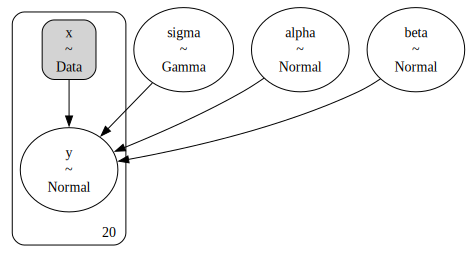

In [ ]:
N = 20

with pm.Model() as model:
    x_data = pm.Data("x", x_values) # <1>

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")
    mu = alpha + beta * x_data # Use 'x_data' instead of 'x'
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

1. Registers `"x"` in the model.

And when we modify the model, the `Data` for `x` is still there.

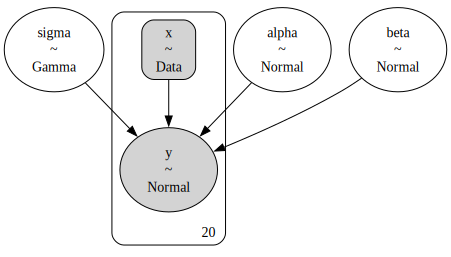

In [45]:
# Simulate values for the parameters
alpha_value, beta_value, sigma_value = pm.draw([alpha, beta, sigma], random_seed=rng)

# Fix parameter values in the mdoel
model_fixed_parameters = pm.do(
    model,
    {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value}
)

# Simulate values for the outcome variable
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Set the outcome values as observed in the original model
model_observed_data = pm.observe(model, {"y": y_values})

# Visualize graph
model_observed_data.to_graphviz()

### Use `coords` and `dims`

In this blog post, we have always used `shape` to indicate the dimensions of a variable.
It works fine, but it's not the recommended approach when using PyMC.
A more robust practice is to use `dims`, which allows us to specify the real-world entities that
each dimension of the variable corresponds to.

For example:

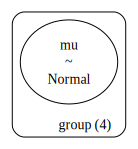

In [46]:
with pm.Model() as model:
    pm.Normal("mu", shape=4, dims="group")

pm.model_to_graphviz(model)

makes it clearer that the lenght of `mu` is 4 because there are 4 groups.

This becomes truly powerful when combined with the usage of `coords`.
While `dims` defines the dimensions of a variable, `coords` provides the length of the dimesions and
the labels for the positions (or indices) within those dimensions.

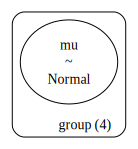

In [47]:
coords = {
    "group": ["Big", "Medium", "Small", "Very small"]
}
with pm.Model(coords=coords) as model:
    pm.Normal("mu", dims="group")

pm.model_to_graphviz(model)

Notice it was not necessary to specify the `shape` manually. It was inferred from the coordinates.

If two variables have the same `dims`, they will have the same shape, and it will be clear their
dimensions are mapped to the same entities.

This is how we could have used `coords` and `dims` in our simple linear regression model:

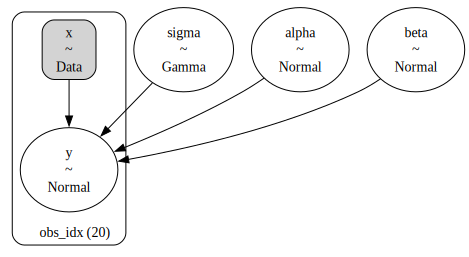

In [48]:
N = 20

coords = {
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    x_data = pm.Data("x", value=x_values, dims="obs_idx")

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")
    mu = alpha + beta * x_data
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, dims="obs_idx")

model.to_graphviz()

And this is how we could have done it for the normal model for multiple groups:

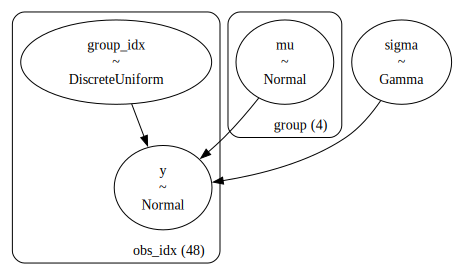

In [49]:
J = 4    # Number of groups
N = 48   # Total number of observations

coords = {
    "group": ["Group 1", "Group 2", "Group 3", "Group 4"],
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    group_idx = pm.DiscreteUniform("group_idx", lower=0, upper=J-1, dims="obs_idx")
    mu = pm.Normal("mu", mu=0, sigma=3, dims="group")
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    pm.Normal("y", mu=mu[group_idx], sigma=sigma, dims="obs_idx")

model.to_graphviz()

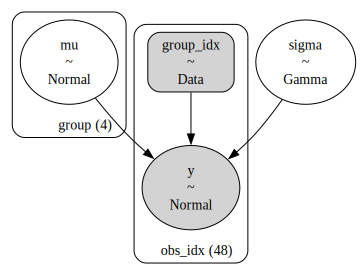

In [50]:
mu_values, sigma_value, group_idx_values = pm.draw([mu, sigma, group_idx], random_seed=rng)

# Fix model parameters _and_ data
model_fixed_parameters = pm.do(
    model,
    {"mu": mu_values, "sigma": sigma_value, "group_idx": group_idx_values}
)

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Observe the outcome values
model_observed_data = pm.observe(
    pm.do(model, {"group_idx": group_idx_values}),
    {"y": y_values}
)

model_observed_data.to_graphviz()

In [51]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


What makes `coords` and `dims` so cool is that everything is labeled, removing the need to mentally map positions to the labels we have in mind.

In [52]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu[Group 1],0.388,0.189,0.028,0.736
mu[Group 2],-3.817,0.150,-4.105,-3.550
mu[Group 3],-3.890,0.157,-4.173,-3.580
mu[Group 4],3.016,0.172,2.680,3.333
sigma,0.568,0.062,0.453,0.681


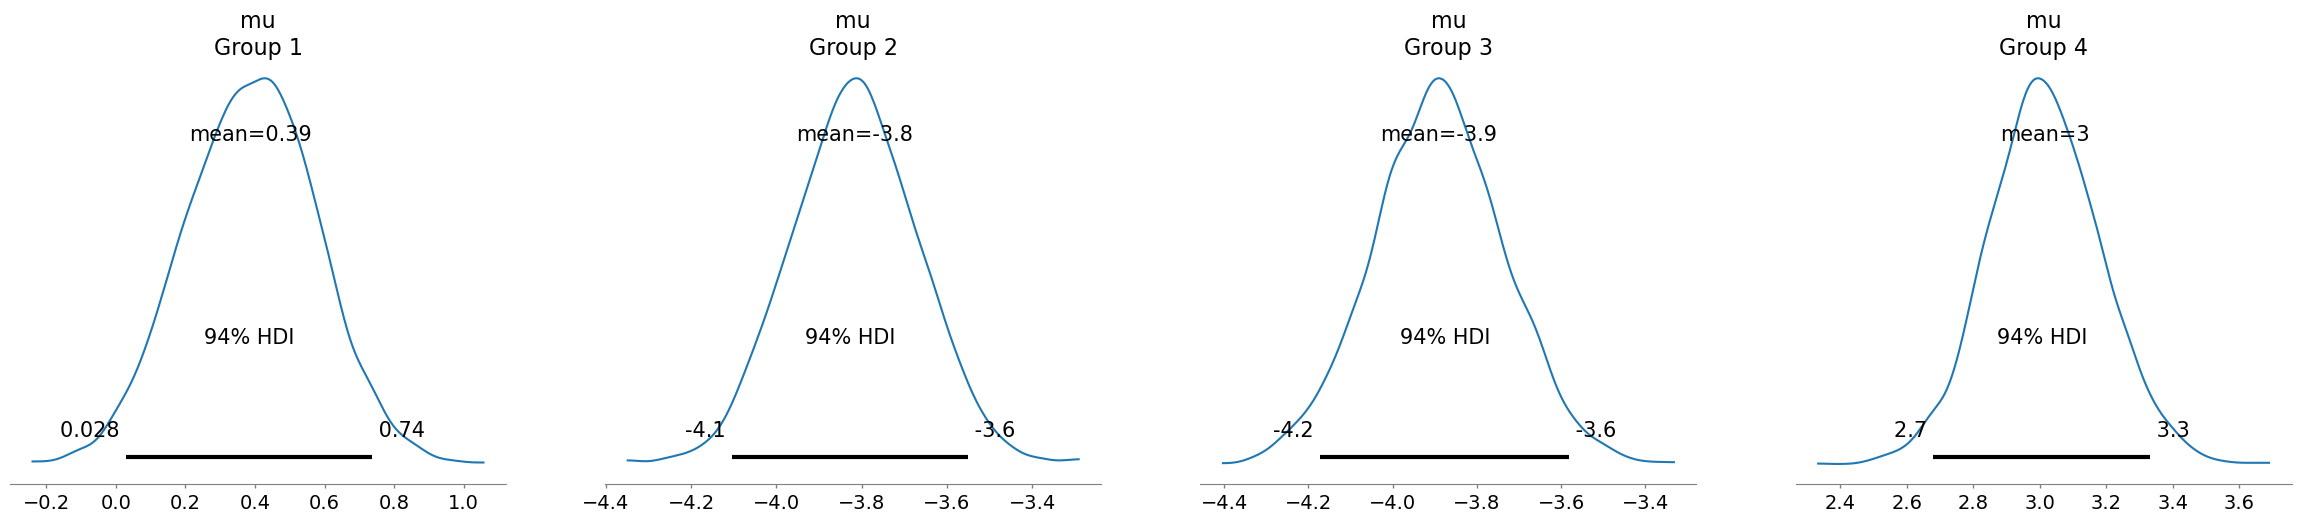

In [53]:
az.plot_posterior(idata, var_names="mu");

Even slicing of the posterior draws becomes easier!

In [54]:
idata.posterior["mu"].sel(group="Group 3")

<xarray.DataArray 'mu' (chain: 4, draw: 1000)> Size: 32kB
array([[-4.03705149, -3.78900314, -3.76479051, ..., -4.04628137,
        -3.88638045, -4.21007427],
       [-3.74006981, -4.03929702, -4.01893038, ..., -3.92875527,
        -3.76260604, -4.02621378],
       [-3.77833314, -3.85270145, -3.86176492, ..., -3.76218849,
        -3.93732774, -3.91962555],
       [-4.25014046, -3.70552177, -3.99825767, ..., -3.76144302,
        -3.61515607, -3.93889675]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    group    <U7 28B 'Group 3'

## A not-so-trivial logistic regression model

Let’s conclude this blog post by applying the concepts discussed in the previous examples to a more advanced example.

Here we work on a logistic regression model with varying intercepts and slopes. The covariates are given by a grouping variable and a continuous variable that represents age.

### Initial attempt

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\pi_i & = \text{expit}(\alpha_{j[i]} + \beta_{j[i]} \times \text{age}_i) \\
\alpha_j &\sim \text{Normal}(0, 1^2) & \text{for all } j \\
\beta_j &\sim \text{Normal}(0, 1^2) & \text{for all } j \\
\end{aligned}
$$

we have $J=3$ groups and $N=200$ observations in total.

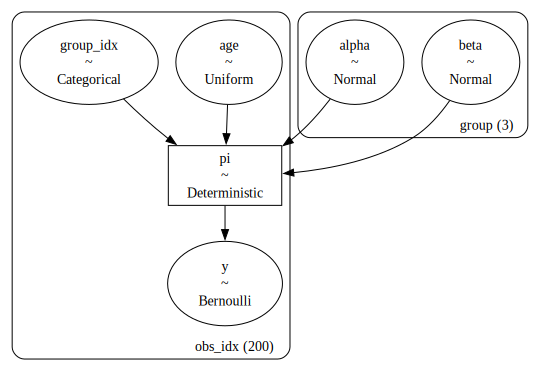

In [55]:
J = 3
p = [0.5, 0.3, 0.2]
N = 200

coords = {
    "group": ["A", "B", "C"],
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    age = pm.Uniform("age", lower=16, upper=70, dims="obs_idx") # <1>
    group_idx = pm.Categorical("group_idx", p=p, dims="obs_idx") # <2>

    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=1, dims="group")

    pi = pm.Deterministic( # <3>
        "pi",
        pm.math.sigmoid(alpha[group_idx] + beta[group_idx] * age),
        dims="obs_idx"
    )

    pm.Bernoulli("y", p=pi, dims="obs_idx")

model.to_graphviz()

1. The age is simulated using a uniform distribution between 18 and 70.
2. For the group memberships, we move from a uniform to a categorical, which enables us to assign different probabilities to each group.
3. We register the success probability `pi` in the model graph using `pm.Deterministic`.
Although `pi` is a random variable, it is represented as deterministic because its values are derived from other random variables and constant values.

At this point, we are quite familiar with what comes below:

alpha: [0.47438197 0.20107513 1.36161128]
beta: [ 0.3889577  -1.65269511  2.58244597]
Groups and their frequencies:
(array([0, 1, 2]), array([98, 58, 44]))


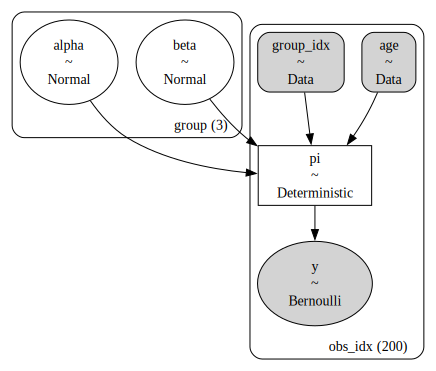

In [56]:
# Simulate values for parameters and data
alpha_values, beta_values, age_values, group_idx_values = pm.draw(
    [alpha, beta, age, group_idx],
    random_seed=rng
)

print("alpha:", alpha_values)
print("beta:", beta_values)

print("Groups and their frequencies:")
print(np.unique(group_idx_values, return_counts=True))

# Fix model parameters and_data
model_fixed_parameters = pm.do(
    model,
    {
        "alpha": alpha_values,
        "beta": beta_values,
        "age": age_values,
        "group_idx": group_idx_values
    }
)

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Fix covariate values and observe the outcome
model_observed_data = pm.observe(
    pm.do(model, {"age": age_values, "group_idx": group_idx_values}),
    {"y": y_values}
)

model_observed_data.to_graphviz()

And, finally, we can get out sampler rolling:

In [57]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 3306 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Well, it seems to be not working.

### Taking the covariate scale into account

The main goal of the blog post is not to show you what to do to diagnose the model and/or sampler when things are not working, so I will get straight to the solution.

The sampler above is failing because the scale of the `age` covariate,
combined with the slope parameters,
resulted in an extremely large contribution to the linear predictor,
which somehow ruined our computation.

One solution is to use a standardized version of age:

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\pi_i & = \text{expit}(\alpha_{j[i]} + \beta_{j[i]} \times \text{age}^*_i) \\
\alpha_j &\sim \text{Normal}(0, 1^2) & \text{for all } j \\
\beta_j &\sim \text{Normal}(0, 1^2) & \text{for all } j \\
\end{aligned}
$$

where

$$
\text{age}^*_i = \frac{\text{age}_i - \text{mean}(\text{age})}{\text{std}(\text{age})}
$$

We need to import `pytensor.tensor` to compute the standard deviation of PyMC random variables.

In [58]:
import pytensor.tensor as pt

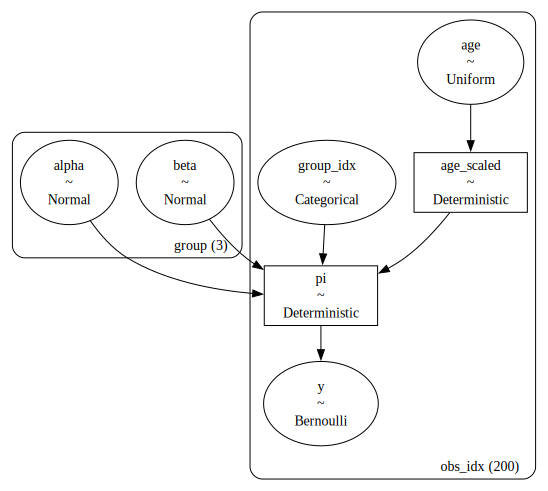

In [59]:
J = 3
p = [0.5, 0.3, 0.2]
N = 200

coords = {
    "group": ["A", "B", "C"],
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    age = pm.Uniform("age", lower=16, upper=70, dims="obs_idx")
    group_idx = pm.Categorical("group_idx", p=p, dims="obs_idx")

    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=1, dims="group")

    age_scaled = pm.Deterministic(
        "age_scaled", (age - pt.mean(age)) / pt.std(age), dims="obs_idx"
    )

    pi = pm.Deterministic(
        "pi",
        pm.math.sigmoid(alpha[group_idx] + beta[group_idx] * age_scaled),
        dims="obs_idx"
    )

    pm.Bernoulli("y", p=pi, dims="obs_idx")

model.to_graphviz()

It’s lovely to see how things come together in the graph. Let's simulate now.

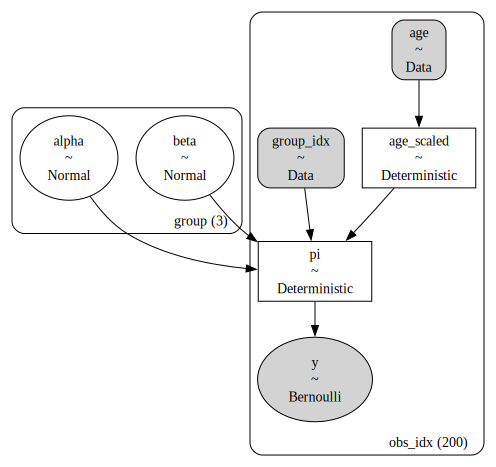

In [60]:
# Fix model parameters and data, use the ones we got before
model_fixed_parameters = pm.do(
    model,
    {
        "alpha": alpha_values,
        "beta": beta_values,
        "age": age_values,
        "group_idx": group_idx_values
    }
)

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Fix covariate values and observe the outcome
model_observed_data = pm.observe(
    pm.do(model, {"age": age_values, "group_idx": group_idx_values}),
    {"y": y_values}
)

model_observed_data.to_graphviz()

Fingers crossed!

In [61]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


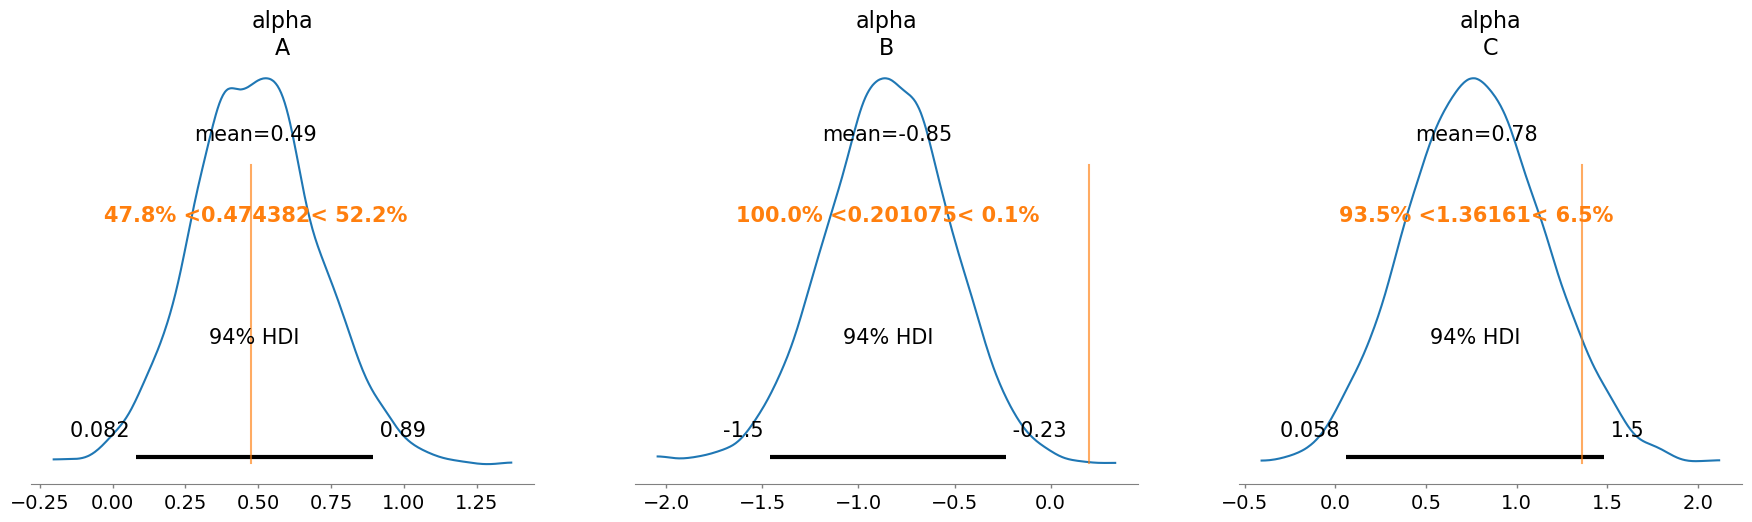

In [62]:
az.plot_posterior(idata, var_names="alpha", ref_val=alpha_values.tolist());

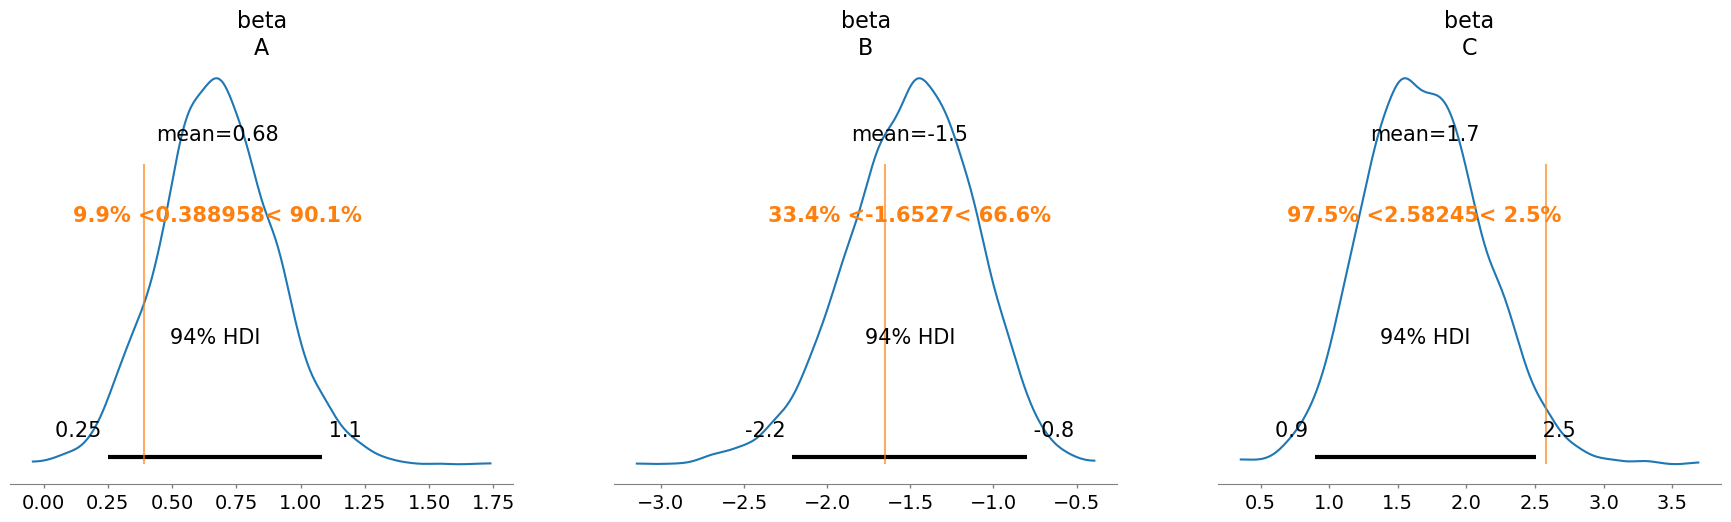

In [63]:
az.plot_posterior(idata, var_names="beta", ref_val=beta_values.tolist());

The sampler worked perfectly this time, and we can also see that the posterior successfully recovered the true parameter values.

### Out of model predictions

To conclude this blog post, I would like to quickly show one last feature of PyMC that I really like: out of model predictions.

Imagine we want to see how the probability of success changes with age for the different groups.
To create such a plot, we need a grid of age values along with posterior draws of $\pi$ conditional on each age value and group.
However, the age values we currently have are not organized in a grid, they are just random. What should we do?

One can always manually work with the posterior draws to perform the necessary computations.
But I usually prefer to let PyMC do that for me.

We are going to create a **new** PyMC model, which is like the previous logistic regression model,
but uses the grid of age values that we want. Then, we are going to ask PyMC to "predict" (compute)
the values of $\pi$ in this model using the draws we obtained with the previous model. 
That's out of model prediction.

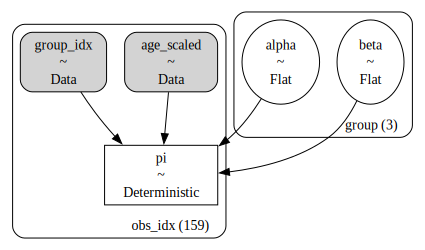

In [64]:
age_mean = np.mean(age_values) # <1>
age_std = np.std(age_values)

age_range = np.arange(18, 71)
age_values = np.tile(age_range, J)
group_idx = np.repeat(np.arange(J), len(age_range))

coords = {
    "group": ["A", "B", "C"],
    "obs_idx": np.arange(len(age_values))
}

with pm.Model(coords=coords) as model:
    age_scaled_data = pm.Data("age_scaled", (age_values - age_mean) / age_std, dims="obs_idx")
    group_idx_data = pm.Data("group_idx", group_idx, dims="obs_idx")

    alpha = pm.Flat("alpha", dims="group") # <2>
    beta = pm.Flat("beta", dims="group")

    pi = pm.Deterministic(
        "pi",
        pm.math.sigmoid(alpha[group_idx_data] + beta[group_idx_data] * age_scaled_data),
        dims="obs_idx"
    )
    # <3>

model.to_graphviz()

1. Covariate transformations have to be done with the original summaries.
2. The `pm.Flat` objects represent distributions from which sampling is not possible. We use them to be extra sure the forward sampling below uses the draws available in `idata`.
3. Since our goal is not to predict values of `y`, it does not need to be defined in this new model.

Notice we do forward sampling specifying we want to sample from `pi` and setting `predictions=True`, which gives us a new group.

In [65]:
with model:
    predictions = pm.sample_posterior_predictive(
        idata, var_names=["pi"], predictions=True, random_seed=rng
    )["predictions"]

Sampling: []


Output()

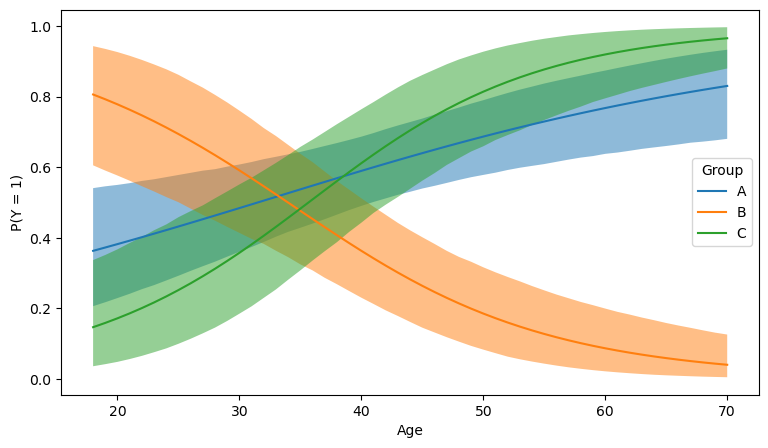

In [66]:
pi_mean = predictions["pi"].mean(("chain", "draw")) # <1>
pi_lower, pi_upper = predictions["pi"].quantile((0.025, 0.975), ("chain", "draw")) # <2>

fig, ax = plt.subplots(figsize=(9, 5))

for j, group in enumerate(["A", "B", "C"]):
    ax.plot(age_range, pi_mean.sel(obs_idx=group_idx==j), label=group)
    ax.fill_between(
        age_range,
        pi_lower.sel(obs_idx=group_idx==j),
        pi_upper.sel(obs_idx=group_idx==j),
        alpha=0.5
    )

ax.legend(title="Group")
ax.set(xlabel="Age", ylabel="P(Y = 1)");

1. Compute the mean of $\pi$ across all chains and draws. It gives the mean for every observation.
2. Compute quantiles of $\pi$ across all chains and draws. It gives the bounds for a credible interval of $\pi$ for every observation.

## Where to go next

If you, like me, enjoyed exploring these less obvious uses of PyMC, I invite you to check out two other articles I co-authored with Ricardo Vieira. They go deeper into advanced data simulation and out-of-model predictions with PyMC.

* [Simulating data with PyMC](https://www.pymc-labs.com/blog-posts/simulating-data-with-pymc/)
* [Out of model predictions with PyMC](https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/)